# 1. Importing modules and functions

In [3]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import MACCSkeys
from copy import deepcopy
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
def convert_smi_to_canon_smi(smi):
    
    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [5]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

## Load data and curation work set

In [7]:
# Set file path
df_ws=pd.read_csv('datasets/rat_LD50_WS.csv')
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382
...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466


##  Standardization  for work set

In [9]:
df_ws["Molecule"] = df_ws.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
print('Kept data: ', len(df_ws), 'molecules')

Kept data:  1858 molecules


In [10]:
df_ws

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-3990,178,acetamide,CC(N)=O,CC(N)=O,DLFVBJFMPXGRIB-UHFFFAOYSA-N,0.674442,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
1,TOX-2407,180,propan-2-one,CC(C)=O,CC(C)=O,CSCPPACGZOOCGX-UHFFFAOYSA-N,1.023664,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
2,TOX-8193,12025,pyrrolidin-2-one,O=C1CCCN1,O=C1CCCN1,HNJBEVLQSNELDL-UHFFFAOYSA-N,1.072628,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
3,TOX-4318,1030,"propane-1,2-diol",CC(O)CO,CC(O)CO,DNIAPMSPPWPWGF-UHFFFAOYSA-N,1.073618,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
4,TOX-8477,99937,"2,3,3a,5,6,6a-hexahydrofuro[3,2-b]furan-3,6-diol",OC1COC2C(O)COC12,OC1COC2C(O)COC12,KLDXJTOLSGUMSJ-UHFFFAOYSA-N,1.123382,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
...,...,...,...,...,...,...,...,...
1853,TOX-43158,116224,2-diethoxyphosphorylsulfanylethyl-ethyl-methyl...,CCOP(=O)(OCC)SCC[S+](C)CC,CCOP(=O)(OCC)SCC[S+](C)CC,YDYNMVNUGKEYOS-UHFFFAOYSA-N,7.232647,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
1854,TOX-2075,14955,"9,10,21,25-tetramethoxy-15,15,30,30-tetramethy...",COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,COc1ccc2cc1Oc1cc3c(cc1OC)CC[N+](C)(C)C3Cc1ccc(...,JFXBEKISTKFVAB-UHFFFAOYSA-N,7.270733,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
1855,TOX-43154,116216,2-diethoxyphosphorylsulfanylethyl(diethyl)sulf...,CCOP(=O)(OCC)SCC[S+](CC)CC,CCOP(=O)(OCC)SCC[S+](CC)CC,QACHTXIQQRWDTM-UHFFFAOYSA-N,7.458497,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
1856,TOX-43157,116222,2-dimethoxyphosphorylsulfanylethyl-ethyl-(2-et...,CCSCC[S+](CC)CCSP(=O)(OC)OC,CCSCC[S+](CC)CCSP(=O)(OC)OC,GICPMZCWCHOATC-UHFFFAOYSA-N,7.805466,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...


In [11]:
y_tr=df_ws.rat_intravenous_LD50	
y_tr

0       0.674442
1       1.023664
2       1.072628
3       1.073618
4       1.123382
          ...   
1853    7.232647
1854    7.270733
1855    7.458497
1856    7.805466
1857    7.842020
Name: rat_intravenous_LD50, Length: 1858, dtype: float64

In [12]:
moldf_ws=df_ws.Molecule

##  Load data and curation test set

In [14]:
df_ts=pd.read_csv('datasets/rat_LD50_TS.csv')
df_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244
...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383


##  Standardization  for test set

In [16]:
df_ts["Molecule"] = df_ts.apply(lambda x: standart(x.Canonical_SMILES), axis=1)
moldf_ts=df_ts[df_ts['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  465 molecules


In [17]:
moldf_ts

,TAID,Pubchem CID,IUPAC Name,SMILES,Canonical_SMILES,InChIKey,rat_intravenous_LD50,Molecule
0,TOX-69105,9887295,"1-[6-(benzenesulfonyl)-3-hydroxy-2,2-dimethyl-...",CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,CC1(C)Oc2ccc(S(=O)(=O)c3ccccc3)cc2C(N2CCCC2=O)C1O,LKAQWOWWTKFLNX-UHFFFAOYSA-N,0.496458,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
1,TOX-5811,8172,2-[2-(2-hydroxyethoxy)ethoxy]ethanol,OCCOCCOCCO,OCCOCCOCCO,ZIBGPFATKBEMQZ-UHFFFAOYSA-N,1.108409,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
2,TOX-2835,4101,"1,3,5,7-tetrazatricyclo[3.3.1.13,7]decane",C1N2CN3CN1CN(C2)C3,C1N2CN3CN1CN(C2)C3,VKYKSIONXSXAKP-UHFFFAOYSA-N,1.182929,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
3,TOX-3906,174,"ethane-1,2-diol",OCCO,OCCO,LYCAIKOWRPUZTN-UHFFFAOYSA-N,1.279650,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
4,TOX-5749,8087,1-(2-hydroxypropoxy)propan-2-ol,CC(O)COCC(C)O,CC(O)COCC(C)O,AZUXKVXMJOIAOF-UHFFFAOYSA-N,1.364244,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1C...
...,...,...,...,...,...,...,...,...
460,TOX-44743,76419053,"[4-[4-[4-[3,5-dihydroxy-6-(hydroxymethyl)-4-[3...",CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,CC1(C)CCC2(C(=O)OC3OC(CO)C(O)C(OC4OC(CO)C(O)C(...,UZQJVUCHXGYFLQ-UHFFFAOYSA-N,6.425276,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1D...
461,TOX-5571,7871,2-[fluoro(methyl)phosphoryl]oxypropane,CC(C)OP(C)(=O)F,CC(C)OP(C)(=O)F,DYAHQFWOVKZOOW-UHFFFAOYSA-N,6.555355,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1D...
462,TOX-5132,7305,"3-[fluoro(methyl)phosphoryl]oxy-2,2-dimethylbu...",CC(OP(C)(=O)F)C(C)(C)C,CC(OP(C)(=O)F)C(C)(C)C,GRXKLBBBQUKJJZ-UHFFFAOYSA-N,6.612129,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1D...
463,TOX-23193,102302,"2-[ethoxy(methyl)phosphoryl]sulfanyl-N,N-dimet...",CCOP(C)(=O)SCCN(C)C,CCOP(C)(=O)SCCN(C)C,PKDYQTANBZBIRM-UHFFFAOYSA-N,7.094383,<rdkit.Chem.rdchem.Mol object at 0x000001AEA1D...


In [18]:
y_ts=moldf_ts.rat_intravenous_LD50	
y_ts

0      0.496458
1      1.108409
2      1.182929
3      1.279650
4      1.364244
         ...   
460    6.425276
461    6.555355
462    6.612129
463    7.094383
464    7.582023
Name: rat_intravenous_LD50, Length: 465, dtype: float64

In [19]:
moldf_ts=moldf_ts.Molecule

## Calculation MACCS Fingerprints for work set

In [21]:
fp_tr = [MACCSkeys.GenMACCSKeys(m) for m in moldf_ws]

In [22]:
def rdkit_numpy_convert(fp_tr):
    output = []
    for f in fp_tr:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [23]:
from numpy import savetxt
x_tr = rdkit_numpy_convert(fp_tr)

In [24]:
savetxt('models/MACCS/x_tr_MACCS.csv', x_tr, delimiter=',')

In [25]:
x_tr.shape

(1858, 167)

In [58]:
columns = [f"MACCS_key_{i}" for i in range(167)]

In [60]:
df_RDKit_2D = pd.DataFrame(x_tr, columns=columns)

In [62]:
df_RDKit_2D

,MACCS_key_0,MACCS_key_1,MACCS_key_2,MACCS_key_3,MACCS_key_4,MACCS_key_5,MACCS_key_6,MACCS_key_7,MACCS_key_8,MACCS_key_9,...,MACCS_key_157,MACCS_key_158,MACCS_key_159,MACCS_key_160,MACCS_key_161,MACCS_key_162,MACCS_key_163,MACCS_key_164,MACCS_key_165,MACCS_key_166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Calculation  MACCS Fingerprint for test set

In [27]:
fp_ts = [MACCSkeys.GenMACCSKeys(m) for m in moldf_ts]

In [28]:
def rdkit_numpy_convert(fp_ts):
    output = []
    for f in fp_ts:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

In [29]:
x_ts = rdkit_numpy_convert(fp_ts)

In [30]:
x_ts.shape

(465, 167)

In [35]:
x_tr = np.array(x_tr, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

# CatBoostRegressor

In [55]:
cv=KFold(n_splits=5, random_state=42, shuffle=True)

In [57]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 1min 43s
Wall time: 15min 58s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020B7DF735C0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [58]:
best_CatBR = grid.best_estimator_

In [59]:
grid.best_params_

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}

In [60]:
y_pred_ws_GBR = best_CatBR.predict(x_tr)

In [61]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.98

In [62]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.15

In [63]:
params={'verbose': False}

In [64]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, fit_params=params)

CPU times: total: 3min 32s
Wall time: 24.3 s


In [65]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.6

In [66]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.62

# save the model to disk

In [155]:
pickle.dump(best_CatBR, open('Models/MACCS/Toxicity_CatBoost_MACCS.pkl', 'wb'))

# load the model from disk

In [68]:
best_CatBR = pickle.load(open('Models/MACCS/Toxicity_CatBoost_MACCS.pkl', 'rb'))

# 9. Prediction for test set's molecules

In [71]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [73]:
y_pred_GBR = best_CatBR.predict(x_ts)

In [75]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.51

In [77]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.69

# Calculate Feature Importance

In [79]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': df_RDKit_2D.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

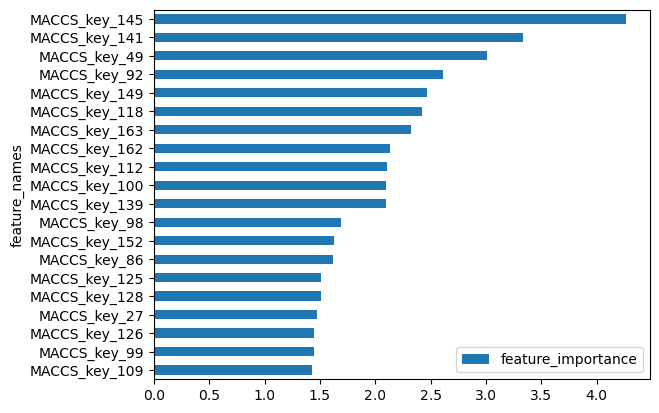

In [81]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

# Y-randomization GradientBoostingRegressor model

In [165]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           fit_params=params,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

True score =  0.6 
Y-randomization =  -0.3 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [168]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [170]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,2.236068,2.236068,2.645751,3.605551,2.236068,2.449490,2.449490,3.000000,2.236068,...,0.000000,1.414214,3.000000,1.000000,4.582576,1.414214,1.000000,0.000000,1.414214,0.000000
2,3.162278,2.645751,3.741657,3.000000,3.605551,2.449490,2.449490,2.449490,3.741657,2.236068,...,0.000000,2.645751,3.316625,1.414214,4.690416,1.414214,1.414214,1.414214,1.414214,1.414214
3,3.162278,2.645751,4.000000,3.162278,3.605551,3.162278,2.828427,2.645751,3.741657,2.449490,...,1.414214,4.242640,4.582576,3.000000,4.795832,1.414214,2.645751,1.414214,1.414214,1.414214
4,3.162278,2.828427,4.000000,3.162278,3.872983,3.316625,2.828427,2.645751,3.741657,2.645751,...,3.316625,4.242640,4.690416,3.464102,4.795832,1.414214,3.162278,1.414214,1.414214,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.544003,8.831760,8.306623,8.774964,8.485281,8.774964,8.602325,8.831760,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,8.944272,8.888194,8.485281,8.774964,8.774964,8.774964
1854,8.660254,8.888194,8.426149,8.774964,8.485281,8.774964,8.602325,8.888194,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,9.000000,8.888194,8.485281,8.831760,8.774964,8.831760
1855,8.774964,9.110434,8.485281,8.944272,8.544003,8.888194,8.660254,8.944272,8.124039,8.831760,...,8.660254,8.774964,9.110434,8.602325,9.000000,8.888194,8.602325,8.831760,8.888194,8.831760
1856,8.831760,9.219544,8.544003,9.110434,8.602325,9.055386,8.660254,9.165152,8.185352,9.000000,...,8.660254,8.774964,9.110434,8.774964,9.110434,9.000000,8.831760,8.888194,8.888194,8.888194


In [172]:
similarity= neighbors_k

In [174]:
Dmean=np.mean(similarity[1,:])

In [176]:
round(Dmean, 2)

2.53

In [178]:
std=np.std(similarity[1,:])

In [180]:
round(std, 2)

1.15

In [182]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.11


In [184]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [186]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,5.385165,1.000000,2.645751,2.449490,2.449490,1.732051,2.236068,4.123106,1.732051,1.414214,...,0.000000,4.000000,0.000000,4.582576,3.162278,1.000000,2.828427,3.000000,3.316625,3.464102
1,5.477226,2.449490,3.000000,2.449490,3.000000,2.645751,2.449490,4.242640,1.732051,2.449490,...,2.000000,4.123106,1.414214,4.795832,3.316625,1.732051,3.000000,3.162278,3.464102,3.605551
2,5.477226,2.449490,3.741657,2.645751,3.162278,2.828427,3.316625,4.582576,2.449490,2.449490,...,2.000000,4.358899,1.414214,4.898980,3.464102,1.732051,3.316625,3.464102,3.464102,3.605551
3,5.567764,2.645751,4.000000,2.828427,3.316625,3.316625,3.316625,4.690416,2.449490,2.645751,...,3.000000,4.358899,1.414214,4.898980,3.605551,2.236068,3.464102,3.605551,3.605551,3.741657
4,5.744563,2.828427,4.000000,3.000000,3.316625,3.464102,3.605551,4.690416,2.645751,3.162278,...,3.162278,4.358899,1.414214,4.898980,3.605551,2.236068,3.605551,3.741657,3.741657,3.872983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.602325,8.774964,8.366600,8.831760,8.717798,8.660254,8.366600,8.544003,8.306623,8.306623,...,8.831760,8.366600,8.888194,7.937254,8.774964,9.165152,8.944272,8.944272,8.660254,8.485281
1854,8.660254,8.774964,8.485281,8.831760,8.717798,8.717798,8.366600,8.544003,8.366600,8.366600,...,8.888194,8.485281,8.888194,8.062258,8.831760,9.273619,9.055386,9.110434,8.717798,8.544003
1855,8.660254,8.774964,8.544003,9.000000,8.774964,8.774964,8.485281,8.544003,8.366600,8.426149,...,8.944272,8.485281,8.888194,8.062258,8.888194,9.273619,9.055386,9.110434,8.774964,8.602325
1856,8.717798,8.944272,8.831760,9.000000,8.888194,8.774964,8.544003,8.602325,8.366600,8.544003,...,9.165152,8.602325,9.000000,8.124039,8.888194,9.380832,9.055386,9.110434,8.774964,8.602325


In [188]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.385 1.    2.646 2.449 2.449 1.732 2.236 4.123 1.732 1.414 2.236 4.
 0.    2.449 3.873 2.646 3.464 1.732 4.243 3.464 3.873 4.243 3.873 3.606
 3.162 3.162 2.646 4.    1.414 1.414 2.646 2.646 2.828 3.317 2.646 2.
 4.    3.873 2.449 3.162 4.69  1.732 3.606 1.414 5.196 1.    4.796 2.828
 1.414 2.646 2.449 1.    1.    3.606 1.414 2.236 3.162 4.243 3.464 2.
 2.    1.414 4.123 4.123 1.732 1.414 4.123 2.    4.243 4.    2.    3.606
 3.162 3.606 4.243 4.472 2.828 4.472 1.732 3.317 3.464 2.236 0.    2.449
 3.742 3.742 4.    4.472 4.    1.    3.162 3.464 3.606 2.236 3.162 2.236
 1.732 2.    1.732 3.464 2.236 2.    3.162 3.606 4.    3.162 3.606 3.317
 3.317 2.449 3.    4.    3.    2.646 1.414 3.742 1.732 1.732 1.732 3.162
 3.873 1.732 2.646 1.414 0.    2.236 3.    2.828 3.606 2.236 3.162 1.732
 3.464 2.828 0.    4.    3.162 2.828 3.742 1.414 2.828 4.899 4.899 1.414
 3.162 2.449 4.123 4.    2.646 3.464 0.    3.162 2.236 3.317 3.317 1.414
 3.    4.    2.449 3.742 3.873 3.    2.236 3.606 5.099 4.   

In [190]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True False  True  True  True False
  True  True False  True False  True False False False False False False
 False False  True False  True  True  True  True  True False  True  True
 False False  True False False  True False  True False  True False  True
  True  True  True  True  True False  True  True False False False  True
  True  True False False  True  True False  True False False  True False
 False False False False  True False  True False False  True  True  True
 False False False False False  True False False False  True False  True
  True  True  True False  True  True False False False False False False
 False  True  True False  True  True  True False  True  True  True False
 False  True  True  True  True  True  True  True False  True False  True
 False  True  True False False  True False  True  True False False  True
 False  True False False  True False  True False  True False False  True
  True False  True False False  True  True False Fa

In [192]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.65


In [194]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   8   9  10  12  13  15  17  26  28  29  30  31
  32  34  35  38  41  43  45  47  48  49  50  51  52  54  55  59  60  61
  64  65  67  70  76  78  81  82  83  89  93  95  96  97  98 100 101 109
 110 112 113 114 116 117 118 121 122 123 124 125 126 127 129 131 133 134
 137 139 140 143 145 148 150 152 155 156 158 161 162 166 167 168 169 171
 172 173 174 175 177 178 180 182 186 188 189 190 191 193 194 195 197 198
 200 202 203 204 205 206 207 210 211 213 214 216 219 220 222 224 225 226
 227 229 230 231 233 234 236 237 238 239 241 242 243 244 245 246 247 248
 249 250 251 253 256 258 259 260 263 264 266 268 269 270 272 273 275 276
 278 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 300 302 304 307 308 311 312 314 315 316 317 318 319 320 321 322 323
 325 326 327 330 331 332 333 334 335 336 337 338 341 343 344 345 346 348
 349 351 352 354 355 356 358 359 361 362 363 364 365 366 367 368 369 371
 372 373 37

In [196]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [199]:
y_pred_GBR_ad=list(y_pred_GBR)

In [201]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [203]:
len(y_pred_GBR_ad)

300

In [205]:
y_ts_ad=list(y_ts)

In [207]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [209]:
len(y_ts_ad)

300

In [211]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.63

In [213]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.57

# SVM model building and validation

In [217]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [219]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [220]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [223]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [224]:
svm.best_params_
best_svm = svm.best_estimator_

In [225]:
svm.best_params_

{'C': 10, 'gamma': 0.1}

In [226]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [227]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.96

In [228]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.19

In [229]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [230]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.58

In [231]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.64

# Prediction for test set's molecules

In [233]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [234]:
y_pred_svm = best_svm.predict(x_ts)

In [235]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.51

In [236]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.69

save the model to disk

In [238]:
pickle.dump(best_svm, open('models/MACCS/Toxicity_SVM_MACCS.pkl', 'wb'))

load the model from disk

In [105]:
best_svm = pickle.load(open('models/MACCS/Toxicity_SVM_MACCS.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [254]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [256]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,2.236068,2.236068,2.645751,3.605551,2.236068,2.449490,2.449490,3.000000,2.236068,...,0.000000,1.414214,3.000000,1.000000,4.582576,1.414214,1.000000,0.000000,1.414214,0.000000
2,3.162278,2.645751,3.741657,3.000000,3.605551,2.449490,2.449490,2.449490,3.741657,2.236068,...,0.000000,2.645751,3.316625,1.414214,4.690416,1.414214,1.414214,1.414214,1.414214,1.414214
3,3.162278,2.645751,4.000000,3.162278,3.605551,3.162278,2.828427,2.645751,3.741657,2.449490,...,1.414214,4.242640,4.582576,3.000000,4.795832,1.414214,2.645751,1.414214,1.414214,1.414214
4,3.162278,2.828427,4.000000,3.162278,3.872983,3.316625,2.828427,2.645751,3.741657,2.645751,...,3.316625,4.242640,4.690416,3.464102,4.795832,1.414214,3.162278,1.414214,1.414214,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.544003,8.831760,8.306623,8.774964,8.485281,8.774964,8.602325,8.831760,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,8.944272,8.888194,8.485281,8.774964,8.774964,8.774964
1854,8.660254,8.888194,8.426149,8.774964,8.485281,8.774964,8.602325,8.888194,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,9.000000,8.888194,8.485281,8.831760,8.774964,8.831760
1855,8.774964,9.110434,8.485281,8.944272,8.544003,8.888194,8.660254,8.944272,8.124039,8.831760,...,8.660254,8.774964,9.110434,8.602325,9.000000,8.888194,8.602325,8.831760,8.888194,8.831760
1856,8.831760,9.219544,8.544003,9.110434,8.602325,9.055386,8.660254,9.165152,8.185352,9.000000,...,8.660254,8.774964,9.110434,8.774964,9.110434,9.000000,8.831760,8.888194,8.888194,8.888194


In [258]:
similarity= neighbors_k

In [260]:
Dmean=np.mean(similarity[1,:])

In [262]:
round(Dmean, 2)

2.53

In [264]:
std=np.std(similarity[1,:])

In [266]:
round(std, 2)

1.15

In [268]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.11


In [270]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [272]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,5.385165,1.000000,2.645751,2.449490,2.449490,1.732051,2.236068,4.123106,1.732051,1.414214,...,0.000000,4.000000,0.000000,4.582576,3.162278,1.000000,2.828427,3.000000,3.316625,3.464102
1,5.477226,2.449490,3.000000,2.449490,3.000000,2.645751,2.449490,4.242640,1.732051,2.449490,...,2.000000,4.123106,1.414214,4.795832,3.316625,1.732051,3.000000,3.162278,3.464102,3.605551
2,5.477226,2.449490,3.741657,2.645751,3.162278,2.828427,3.316625,4.582576,2.449490,2.449490,...,2.000000,4.358899,1.414214,4.898980,3.464102,1.732051,3.316625,3.464102,3.464102,3.605551
3,5.567764,2.645751,4.000000,2.828427,3.316625,3.316625,3.316625,4.690416,2.449490,2.645751,...,3.000000,4.358899,1.414214,4.898980,3.605551,2.236068,3.464102,3.605551,3.605551,3.741657
4,5.744563,2.828427,4.000000,3.000000,3.316625,3.464102,3.605551,4.690416,2.645751,3.162278,...,3.162278,4.358899,1.414214,4.898980,3.605551,2.236068,3.605551,3.741657,3.741657,3.872983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.602325,8.774964,8.366600,8.831760,8.717798,8.660254,8.366600,8.544003,8.306623,8.306623,...,8.831760,8.366600,8.888194,7.937254,8.774964,9.165152,8.944272,8.944272,8.660254,8.485281
1854,8.660254,8.774964,8.485281,8.831760,8.717798,8.717798,8.366600,8.544003,8.366600,8.366600,...,8.888194,8.485281,8.888194,8.062258,8.831760,9.273619,9.055386,9.110434,8.717798,8.544003
1855,8.660254,8.774964,8.544003,9.000000,8.774964,8.774964,8.485281,8.544003,8.366600,8.426149,...,8.944272,8.485281,8.888194,8.062258,8.888194,9.273619,9.055386,9.110434,8.774964,8.602325
1856,8.717798,8.944272,8.831760,9.000000,8.888194,8.774964,8.544003,8.602325,8.366600,8.544003,...,9.165152,8.602325,9.000000,8.124039,8.888194,9.380832,9.055386,9.110434,8.774964,8.602325


In [274]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.385 1.    2.646 2.449 2.449 1.732 2.236 4.123 1.732 1.414 2.236 4.
 0.    2.449 3.873 2.646 3.464 1.732 4.243 3.464 3.873 4.243 3.873 3.606
 3.162 3.162 2.646 4.    1.414 1.414 2.646 2.646 2.828 3.317 2.646 2.
 4.    3.873 2.449 3.162 4.69  1.732 3.606 1.414 5.196 1.    4.796 2.828
 1.414 2.646 2.449 1.    1.    3.606 1.414 2.236 3.162 4.243 3.464 2.
 2.    1.414 4.123 4.123 1.732 1.414 4.123 2.    4.243 4.    2.    3.606
 3.162 3.606 4.243 4.472 2.828 4.472 1.732 3.317 3.464 2.236 0.    2.449
 3.742 3.742 4.    4.472 4.    1.    3.162 3.464 3.606 2.236 3.162 2.236
 1.732 2.    1.732 3.464 2.236 2.    3.162 3.606 4.    3.162 3.606 3.317
 3.317 2.449 3.    4.    3.    2.646 1.414 3.742 1.732 1.732 1.732 3.162
 3.873 1.732 2.646 1.414 0.    2.236 3.    2.828 3.606 2.236 3.162 1.732
 3.464 2.828 0.    4.    3.162 2.828 3.742 1.414 2.828 4.899 4.899 1.414
 3.162 2.449 4.123 4.    2.646 3.464 0.    3.162 2.236 3.317 3.317 1.414
 3.    4.    2.449 3.742 3.873 3.    2.236 3.606 5.099 4.   

In [276]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True False  True  True  True False
  True  True False  True False  True False False False False False False
 False False  True False  True  True  True  True  True False  True  True
 False False  True False False  True False  True False  True False  True
  True  True  True  True  True False  True  True False False False  True
  True  True False False  True  True False  True False False  True False
 False False False False  True False  True False False  True  True  True
 False False False False False  True False False False  True False  True
  True  True  True False  True  True False False False False False False
 False  True  True False  True  True  True False  True  True  True False
 False  True  True  True  True  True  True  True False  True False  True
 False  True  True False False  True False  True  True False False  True
 False  True False False  True False  True False  True False False  True
  True False  True False False  True  True False Fa

In [278]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.65


In [280]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   8   9  10  12  13  15  17  26  28  29  30  31
  32  34  35  38  41  43  45  47  48  49  50  51  52  54  55  59  60  61
  64  65  67  70  76  78  81  82  83  89  93  95  96  97  98 100 101 109
 110 112 113 114 116 117 118 121 122 123 124 125 126 127 129 131 133 134
 137 139 140 143 145 148 150 152 155 156 158 161 162 166 167 168 169 171
 172 173 174 175 177 178 180 182 186 188 189 190 191 193 194 195 197 198
 200 202 203 204 205 206 207 210 211 213 214 216 219 220 222 224 225 226
 227 229 230 231 233 234 236 237 238 239 241 242 243 244 245 246 247 248
 249 250 251 253 256 258 259 260 263 264 266 268 269 270 272 273 275 276
 278 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 300 302 304 307 308 311 312 314 315 316 317 318 319 320 321 322 323
 325 326 327 330 331 332 333 334 335 336 337 338 341 343 344 345 346 348
 349 351 352 354 355 356 358 359 361 362 363 364 365 366 367 368 369 371
 372 373 37

In [282]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [285]:
y_pred_svm_ad=list(y_pred_svm)

In [287]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [289]:
len(y_pred_svm_ad)

300

In [291]:
y_ts_ad=list(y_ts)

In [293]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [295]:
len(y_ts_ad)

300

In [297]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.64

In [299]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.57

# Multi-layer Perceptron regressor

In [302]:
from sklearn.neural_network import MLPRegressor

In [304]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [306]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [308]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [310]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [5e-05, 0.0005],
                         'hidden_layer_sizes': [(400, 300, 200, 100),
                                                (100, 100, 100), (10, 10, 10),
                                                (50,)],
                         'max_iter': [1000, 2000],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [311]:
best_MLPR = m.best_estimator_

In [312]:
m.best_params_

{'activation': 'relu',
 'alpha': 5e-05,
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 1000,
 'solver': 'adam'}

In [313]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [314]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.99

In [315]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.1

In [316]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [317]:
y_pred_CV_MLPR

array([1.7315433, 1.9446552, 2.7173862, ..., 7.698254 , 7.282101 ,
       7.698254 ], dtype=float32)

In [318]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.52

In [319]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.69

# 9. Prediction for test set's molecules

In [321]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [322]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [323]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.45

In [324]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.73

# save the model to disk

In [326]:
pickle.dump(best_MLPR, open('models/MACCS/Toxicity_MLPR_MACCS.pkl', 'wb'))

# load the model from disk

In [83]:
best_MLPR = pickle.load(open('models/MACCS/Toxicity_MLPR_MACCS.pkl', 'rb'))

# Estimating applicability domain. Method - Euclidian distances, K=1

In [328]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [329]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,2.236068,2.236068,2.645751,3.605551,2.236068,2.449490,2.449490,3.000000,2.236068,...,0.000000,1.414214,3.000000,1.000000,4.582576,1.414214,1.000000,0.000000,1.414214,0.000000
2,3.162278,2.645751,3.741657,3.000000,3.605551,2.449490,2.449490,2.449490,3.741657,2.236068,...,0.000000,2.645751,3.316625,1.414214,4.690416,1.414214,1.414214,1.414214,1.414214,1.414214
3,3.162278,2.645751,4.000000,3.162278,3.605551,3.162278,2.828427,2.645751,3.741657,2.449490,...,1.414214,4.242640,4.582576,3.000000,4.795832,1.414214,2.645751,1.414214,1.414214,1.414214
4,3.162278,2.828427,4.000000,3.162278,3.872983,3.316625,2.828427,2.645751,3.741657,2.645751,...,3.316625,4.242640,4.690416,3.464102,4.795832,1.414214,3.162278,1.414214,1.414214,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.544003,8.831760,8.306623,8.774964,8.485281,8.774964,8.602325,8.831760,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,8.944272,8.888194,8.485281,8.774964,8.774964,8.774964
1854,8.660254,8.888194,8.426149,8.774964,8.485281,8.774964,8.602325,8.888194,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,9.000000,8.888194,8.485281,8.831760,8.774964,8.831760
1855,8.774964,9.110434,8.485281,8.944272,8.544003,8.888194,8.660254,8.944272,8.124039,8.831760,...,8.660254,8.774964,9.110434,8.602325,9.000000,8.888194,8.602325,8.831760,8.888194,8.831760
1856,8.831760,9.219544,8.544003,9.110434,8.602325,9.055386,8.660254,9.165152,8.185352,9.000000,...,8.660254,8.774964,9.110434,8.774964,9.110434,9.000000,8.831760,8.888194,8.888194,8.888194


In [330]:
similarity= neighbors_k

In [331]:
Dmean=np.mean(similarity[1,:])

In [332]:
round(Dmean, 2)

2.53

In [333]:
std=np.std(similarity[1,:])

In [334]:
round(std, 2)

1.15

In [335]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.11


In [336]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [337]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,5.385165,1.000000,2.645751,2.449490,2.449490,1.732051,2.236068,4.123106,1.732051,1.414214,...,0.000000,4.000000,0.000000,4.582576,3.162278,1.000000,2.828427,3.000000,3.316625,3.464102
1,5.477226,2.449490,3.000000,2.449490,3.000000,2.645751,2.449490,4.242640,1.732051,2.449490,...,2.000000,4.123106,1.414214,4.795832,3.316625,1.732051,3.000000,3.162278,3.464102,3.605551
2,5.477226,2.449490,3.741657,2.645751,3.162278,2.828427,3.316625,4.582576,2.449490,2.449490,...,2.000000,4.358899,1.414214,4.898980,3.464102,1.732051,3.316625,3.464102,3.464102,3.605551
3,5.567764,2.645751,4.000000,2.828427,3.316625,3.316625,3.316625,4.690416,2.449490,2.645751,...,3.000000,4.358899,1.414214,4.898980,3.605551,2.236068,3.464102,3.605551,3.605551,3.741657
4,5.744563,2.828427,4.000000,3.000000,3.316625,3.464102,3.605551,4.690416,2.645751,3.162278,...,3.162278,4.358899,1.414214,4.898980,3.605551,2.236068,3.605551,3.741657,3.741657,3.872983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.602325,8.774964,8.366600,8.831760,8.717798,8.660254,8.366600,8.544003,8.306623,8.306623,...,8.831760,8.366600,8.888194,7.937254,8.774964,9.165152,8.944272,8.944272,8.660254,8.485281
1854,8.660254,8.774964,8.485281,8.831760,8.717798,8.717798,8.366600,8.544003,8.366600,8.366600,...,8.888194,8.485281,8.888194,8.062258,8.831760,9.273619,9.055386,9.110434,8.717798,8.544003
1855,8.660254,8.774964,8.544003,9.000000,8.774964,8.774964,8.485281,8.544003,8.366600,8.426149,...,8.944272,8.485281,8.888194,8.062258,8.888194,9.273619,9.055386,9.110434,8.774964,8.602325
1856,8.717798,8.944272,8.831760,9.000000,8.888194,8.774964,8.544003,8.602325,8.366600,8.544003,...,9.165152,8.602325,9.000000,8.124039,8.888194,9.380832,9.055386,9.110434,8.774964,8.602325


In [338]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.385 1.    2.646 2.449 2.449 1.732 2.236 4.123 1.732 1.414 2.236 4.
 0.    2.449 3.873 2.646 3.464 1.732 4.243 3.464 3.873 4.243 3.873 3.606
 3.162 3.162 2.646 4.    1.414 1.414 2.646 2.646 2.828 3.317 2.646 2.
 4.    3.873 2.449 3.162 4.69  1.732 3.606 1.414 5.196 1.    4.796 2.828
 1.414 2.646 2.449 1.    1.    3.606 1.414 2.236 3.162 4.243 3.464 2.
 2.    1.414 4.123 4.123 1.732 1.414 4.123 2.    4.243 4.    2.    3.606
 3.162 3.606 4.243 4.472 2.828 4.472 1.732 3.317 3.464 2.236 0.    2.449
 3.742 3.742 4.    4.472 4.    1.    3.162 3.464 3.606 2.236 3.162 2.236
 1.732 2.    1.732 3.464 2.236 2.    3.162 3.606 4.    3.162 3.606 3.317
 3.317 2.449 3.    4.    3.    2.646 1.414 3.742 1.732 1.732 1.732 3.162
 3.873 1.732 2.646 1.414 0.    2.236 3.    2.828 3.606 2.236 3.162 1.732
 3.464 2.828 0.    4.    3.162 2.828 3.742 1.414 2.828 4.899 4.899 1.414
 3.162 2.449 4.123 4.    2.646 3.464 0.    3.162 2.236 3.317 3.317 1.414
 3.    4.    2.449 3.742 3.873 3.    2.236 3.606 5.099 4.   

In [339]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True False  True  True  True False
  True  True False  True False  True False False False False False False
 False False  True False  True  True  True  True  True False  True  True
 False False  True False False  True False  True False  True False  True
  True  True  True  True  True False  True  True False False False  True
  True  True False False  True  True False  True False False  True False
 False False False False  True False  True False False  True  True  True
 False False False False False  True False False False  True False  True
  True  True  True False  True  True False False False False False False
 False  True  True False  True  True  True False  True  True  True False
 False  True  True  True  True  True  True  True False  True False  True
 False  True  True False False  True False  True  True False False  True
 False  True False False  True False  True False  True False False  True
  True False  True False False  True  True False Fa

In [340]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.65


In [341]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   8   9  10  12  13  15  17  26  28  29  30  31
  32  34  35  38  41  43  45  47  48  49  50  51  52  54  55  59  60  61
  64  65  67  70  76  78  81  82  83  89  93  95  96  97  98 100 101 109
 110 112 113 114 116 117 118 121 122 123 124 125 126 127 129 131 133 134
 137 139 140 143 145 148 150 152 155 156 158 161 162 166 167 168 169 171
 172 173 174 175 177 178 180 182 186 188 189 190 191 193 194 195 197 198
 200 202 203 204 205 206 207 210 211 213 214 216 219 220 222 224 225 226
 227 229 230 231 233 234 236 237 238 239 241 242 243 244 245 246 247 248
 249 250 251 253 256 258 259 260 263 264 266 268 269 270 272 273 275 276
 278 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 300 302 304 307 308 311 312 314 315 316 317 318 319 320 321 322 323
 325 326 327 330 331 332 333 334 335 336 337 338 341 343 344 345 346 348
 349 351 352 354 355 356 358 359 361 362 363 364 365 366 367 368 369 371
 372 373 37

In [342]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [393]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [395]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [397]:
len(y_pred_MLPR_ad)

300

In [399]:
y_ts_ad=list(y_ts)

In [401]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [403]:
len(y_ts_ad)

300

In [405]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.6

In [407]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.6

# k-nearest neighbors

In [410]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [412]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [414]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [415]:
best_kNN = m.best_estimator_

In [416]:
m.best_params_

{'n_neighbors': 7}

In [420]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [421]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.64

In [423]:
RMSE_WS=round(np.sqrt(mean_squared_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.59

In [425]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [427]:
y_pred_CV_kNN

array([1.7639054, 1.8604138, 2.7575834, ..., 5.6279974, 5.710687 ,
       5.6279974], dtype=float32)

In [429]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.48

In [432]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.71

# 9. Prediction for test set's molecules

In [435]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [437]:
y_pred_kNN = best_kNN.predict(x_ts)

In [439]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.4

In [441]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.77

# save the model to disk

In [444]:
pickle.dump(best_kNN, open('models/MACCS/Toxicity_kNN_MACCS.pkl', 'wb'))

# load the model from disk

In [190]:
best_kNN = pickle.load(open('models/MACCS/Toxicity_kNN_MACCS.pkl', 'rb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [447]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [449]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.162278,2.236068,2.236068,2.645751,3.605551,2.236068,2.449490,2.449490,3.000000,2.236068,...,0.000000,1.414214,3.000000,1.000000,4.582576,1.414214,1.000000,0.000000,1.414214,0.000000
2,3.162278,2.645751,3.741657,3.000000,3.605551,2.449490,2.449490,2.449490,3.741657,2.236068,...,0.000000,2.645751,3.316625,1.414214,4.690416,1.414214,1.414214,1.414214,1.414214,1.414214
3,3.162278,2.645751,4.000000,3.162278,3.605551,3.162278,2.828427,2.645751,3.741657,2.449490,...,1.414214,4.242640,4.582576,3.000000,4.795832,1.414214,2.645751,1.414214,1.414214,1.414214
4,3.162278,2.828427,4.000000,3.162278,3.872983,3.316625,2.828427,2.645751,3.741657,2.645751,...,3.316625,4.242640,4.690416,3.464102,4.795832,1.414214,3.162278,1.414214,1.414214,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.544003,8.831760,8.306623,8.774964,8.485281,8.774964,8.602325,8.831760,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,8.944272,8.888194,8.485281,8.774964,8.774964,8.774964
1854,8.660254,8.888194,8.426149,8.774964,8.485281,8.774964,8.602325,8.888194,8.000000,8.831760,...,8.602325,8.660254,9.055386,8.485281,9.000000,8.888194,8.485281,8.831760,8.774964,8.831760
1855,8.774964,9.110434,8.485281,8.944272,8.544003,8.888194,8.660254,8.944272,8.124039,8.831760,...,8.660254,8.774964,9.110434,8.602325,9.000000,8.888194,8.602325,8.831760,8.888194,8.831760
1856,8.831760,9.219544,8.544003,9.110434,8.602325,9.055386,8.660254,9.165152,8.185352,9.000000,...,8.660254,8.774964,9.110434,8.774964,9.110434,9.000000,8.831760,8.888194,8.888194,8.888194


In [451]:
similarity= neighbors_k

In [453]:
Dmean=np.mean(similarity[1,:])

In [455]:
round(Dmean, 2)

2.53

In [457]:
std=np.std(similarity[1,:])

In [459]:
round(std, 2)

1.15

In [461]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

3.11


In [463]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [465]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,5.385165,1.000000,2.645751,2.449490,2.449490,1.732051,2.236068,4.123106,1.732051,1.414214,...,0.000000,4.000000,0.000000,4.582576,3.162278,1.000000,2.828427,3.000000,3.316625,3.464102
1,5.477226,2.449490,3.000000,2.449490,3.000000,2.645751,2.449490,4.242640,1.732051,2.449490,...,2.000000,4.123106,1.414214,4.795832,3.316625,1.732051,3.000000,3.162278,3.464102,3.605551
2,5.477226,2.449490,3.741657,2.645751,3.162278,2.828427,3.316625,4.582576,2.449490,2.449490,...,2.000000,4.358899,1.414214,4.898980,3.464102,1.732051,3.316625,3.464102,3.464102,3.605551
3,5.567764,2.645751,4.000000,2.828427,3.316625,3.316625,3.316625,4.690416,2.449490,2.645751,...,3.000000,4.358899,1.414214,4.898980,3.605551,2.236068,3.464102,3.605551,3.605551,3.741657
4,5.744563,2.828427,4.000000,3.000000,3.316625,3.464102,3.605551,4.690416,2.645751,3.162278,...,3.162278,4.358899,1.414214,4.898980,3.605551,2.236068,3.605551,3.741657,3.741657,3.872983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,8.602325,8.774964,8.366600,8.831760,8.717798,8.660254,8.366600,8.544003,8.306623,8.306623,...,8.831760,8.366600,8.888194,7.937254,8.774964,9.165152,8.944272,8.944272,8.660254,8.485281
1854,8.660254,8.774964,8.485281,8.831760,8.717798,8.717798,8.366600,8.544003,8.366600,8.366600,...,8.888194,8.485281,8.888194,8.062258,8.831760,9.273619,9.055386,9.110434,8.717798,8.544003
1855,8.660254,8.774964,8.544003,9.000000,8.774964,8.774964,8.485281,8.544003,8.366600,8.426149,...,8.944272,8.485281,8.888194,8.062258,8.888194,9.273619,9.055386,9.110434,8.774964,8.602325
1856,8.717798,8.944272,8.831760,9.000000,8.888194,8.774964,8.544003,8.602325,8.366600,8.544003,...,9.165152,8.602325,9.000000,8.124039,8.888194,9.380832,9.055386,9.110434,8.774964,8.602325


In [467]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[5.385 1.    2.646 2.449 2.449 1.732 2.236 4.123 1.732 1.414 2.236 4.
 0.    2.449 3.873 2.646 3.464 1.732 4.243 3.464 3.873 4.243 3.873 3.606
 3.162 3.162 2.646 4.    1.414 1.414 2.646 2.646 2.828 3.317 2.646 2.
 4.    3.873 2.449 3.162 4.69  1.732 3.606 1.414 5.196 1.    4.796 2.828
 1.414 2.646 2.449 1.    1.    3.606 1.414 2.236 3.162 4.243 3.464 2.
 2.    1.414 4.123 4.123 1.732 1.414 4.123 2.    4.243 4.    2.    3.606
 3.162 3.606 4.243 4.472 2.828 4.472 1.732 3.317 3.464 2.236 0.    2.449
 3.742 3.742 4.    4.472 4.    1.    3.162 3.464 3.606 2.236 3.162 2.236
 1.732 2.    1.732 3.464 2.236 2.    3.162 3.606 4.    3.162 3.606 3.317
 3.317 2.449 3.    4.    3.    2.646 1.414 3.742 1.732 1.732 1.732 3.162
 3.873 1.732 2.646 1.414 0.    2.236 3.    2.828 3.606 2.236 3.162 1.732
 3.464 2.828 0.    4.    3.162 2.828 3.742 1.414 2.828 4.899 4.899 1.414
 3.162 2.449 4.123 4.    2.646 3.464 0.    3.162 2.236 3.317 3.317 1.414
 3.    4.    2.449 3.742 3.873 3.    2.236 3.606 5.099 4.   

In [469]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False  True  True  True  True  True  True False  True  True  True False
  True  True False  True False  True False False False False False False
 False False  True False  True  True  True  True  True False  True  True
 False False  True False False  True False  True False  True False  True
  True  True  True  True  True False  True  True False False False  True
  True  True False False  True  True False  True False False  True False
 False False False False  True False  True False False  True  True  True
 False False False False False  True False False False  True False  True
  True  True  True False  True  True False False False False False False
 False  True  True False  True  True  True False  True  True  True False
 False  True  True  True  True  True  True  True False  True False  True
 False  True  True False False  True False  True  True False False  True
 False  True False False  True False  True False  True False False  True
  True False  True False False  True  True False Fa

In [471]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.65


In [473]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  1   2   3   4   5   6   8   9  10  12  13  15  17  26  28  29  30  31
  32  34  35  38  41  43  45  47  48  49  50  51  52  54  55  59  60  61
  64  65  67  70  76  78  81  82  83  89  93  95  96  97  98 100 101 109
 110 112 113 114 116 117 118 121 122 123 124 125 126 127 129 131 133 134
 137 139 140 143 145 148 150 152 155 156 158 161 162 166 167 168 169 171
 172 173 174 175 177 178 180 182 186 188 189 190 191 193 194 195 197 198
 200 202 203 204 205 206 207 210 211 213 214 216 219 220 222 224 225 226
 227 229 230 231 233 234 236 237 238 239 241 242 243 244 245 246 247 248
 249 250 251 253 256 258 259 260 263 264 266 268 269 270 272 273 275 276
 278 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 300 302 304 307 308 311 312 314 315 316 317 318 319 320 321 322 323
 325 326 327 330 331 332 333 334 335 336 337 338 341 343 344 345 346 348
 349 351 352 354 355 356 358 359 361 362 363 364 365 366 367 368 369 371
 372 373 37

In [475]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [478]:
y_pred_kNN_ad=list(y_pred_kNN)

In [480]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [482]:
len(y_pred_kNN_ad)

300

In [484]:
y_ts_ad=list(y_ts)

In [486]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [488]:
len(y_ts_ad)

300

In [490]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.54

In [492]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.64